# 프로젝트: 한영 번역기 만들기

## 데이터 불러오기

In [1]:
# 프로젝트에 사용될 라이브러리 import
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker

import time
import re
import os
import io

import pandas as pd
import urllib.request
from konlpy.tag import Okt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

print(tf.__version__)

2.6.0


In [2]:
path_to_file = os.getenv('HOME')+'/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw_ko = f.read().splitlines()

path_to_file = os.getenv('HOME')+'/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()
    
print("Data Size:", len(raw_ko))
print("Data Size:", len(raw_en))

print("Example:")
for sen_ko, sen_en in zip(raw_ko[0:100][::20], raw_en[0:100][::20]): 
    print(">>", sen_ko, sen_en)

Data Size: 94123
Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?" Much of personal computing is about "can you top this?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다. Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다." “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다. Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다. Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the ki

### 전처리 

In [3]:
#중복치 제거 및 리스트로 만들기 
cleaned_corpus = list(set(zip(raw_ko, raw_en)))

In [4]:
print(len(cleaned_corpus))

78968


In [5]:
# 한글과 영어로 나누기 
clean_corpus_ko = []
clean_corpus_eng = []

for i in range(len(cleaned_corpus)):
    clean_corpus_ko.append(cleaned_corpus[i][0])

for i in range(len(cleaned_corpus)):
    clean_corpus_eng.append(cleaned_corpus[i][1])  

In [6]:
print(clean_corpus_ko[:3])
print(clean_corpus_eng[:3])

['“노장인 커트 워너가 이긴 셈입니다.', "이 네트워크는 오로지 '리사'라는 기증자의 신원만을 공개했다.", '한편 김옥수 탐사계획단장은 분쟁 해역 진입 시점은 날씨 상황에 달려 있다고 밝혔다.']
['“The old guy, Warner, almost won.', 'The network identified the donor only as "Lisa."', 'It is scheduled to conduct its survey in mid-July, although Kim Ok-Soo, a chief survey planner, said the date the ship actually enters disputed territory will depend on weather conditions.']


from konlpy.tag import Mecab
tokenizer = Mecab()

def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = tokenizer.morphs(sentence)
    
    return sentence

def preprocess_sentence_en(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = ' ' + sentence

    if e_token:
        sentence += ' '
    
    sentence = sentence.split()
    
    return sentence

max_len = 40

enc_corpus = []
dec_corpus = []

for sen_ko, sen_en in zip(clean_corpus_ko, clean_corpus_eng):
    if len(sen_ko) <= max_len:
        enc_corpus.append(preprocess_sentence_ko(sen_ko))
        dec_corpus.append(preprocess_sentence_en(sen_en, s_token=True, e_token=True))

print("Korean:", enc_corpus[99])  
print("English:", dec_corpus[99])  

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 a-z A-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
        
    
    return sentence

In [8]:
max_len = 40 #40 글자 자르기 

enc_corpus = []
dec_corpus = []

for sen_ko, sen_en in zip(clean_corpus_ko, clean_corpus_eng):
    if len(sen_ko) <= max_len:
        enc_corpus.append(preprocess_sentence(sen_ko))
        dec_corpus.append(preprocess_sentence(sen_en, s_token=True, e_token=True))

print("Korean:", enc_corpus[50])  
print("English:", dec_corpus[50]) 

Korean: 그는 그날 다른 두 명도 죽인 것으로 여겨진다 .
English: <start> he is also thought to have killed two people earlier in the day . <end>


def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

## 토큰화 

In [9]:
vocab_size = 10000
from konlpy.tag import Mecab
tokenizer = Mecab()

def tokenize_data(train_data, num_words=vocab_size):
    X_train = []
    for sentence in train_data:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        X_train.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 사전 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # 변환 text to index
    X_train = list(map(wordlist_to_indexlist, X_train))

    return X_train, word_to_index

In [10]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
enc_tensor, word_to_index = tokenize_data(enc_corpus)
index_to_word = {index:word for word, index in word_to_index.items()}

enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train = enc_tensor
dec_train = dec_tensor

print("한국 사전 Size:", len(enc_tokenizer.index_word))
print("영어 사전 Size:", len(dec_tokenizer.index_word))

In [26]:
# 토큰화하기
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(enc_tensor,
                                                        value=word_to_index["<PAD>"],                                                            
                                                           padding='post')
#print(enc_tensor[0])

dec_tensor, dec_tokenizer = tokenize(dec_corpus)

enc_train = enc_tensor
dec_train = dec_tensor

In [31]:
print(len(enc_tensor[5]))

25


In [32]:
print(len(dec_tensor[6]))

65


### 모델 만들기 

In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [34]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [36]:
BATCH_SIZE     = 32
SRC_VOCAB_SIZE = vocab_size + 1
TGT_VOCAB_SIZE = vocab_size + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

print(tf.random.uniform((BATCH_SIZE, 1)).shape)
print(sample_state.shape)
print(sample_output.shape)

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 40, 128)
(32, 1)
(32, 128)
(32, 40, 128)
Decoder Output: (32, 10001)
Decoder Hidden State: (32, 128)
Attention: (32, 40, 1)


In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [38]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [40]:
# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    return batch_loss


# Training Process

from tqdm import tqdm
import random
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))


Epoch 15: 100%|██████████| 498/498 [00:56<00:00,  8.74it/s, Loss 0.9327]


# 모델 평가

## 예문 ##
1) 오바마는 대통령이다.

2) 시민들은 도시 속에 산다.

3) 커피는 필요 없다.

4) 일곱 명의 사망자가 발생했다.

In [42]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the two soldier were killed . <end> 


/tmp/ipykernel_604/75899058.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_604/75899058.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


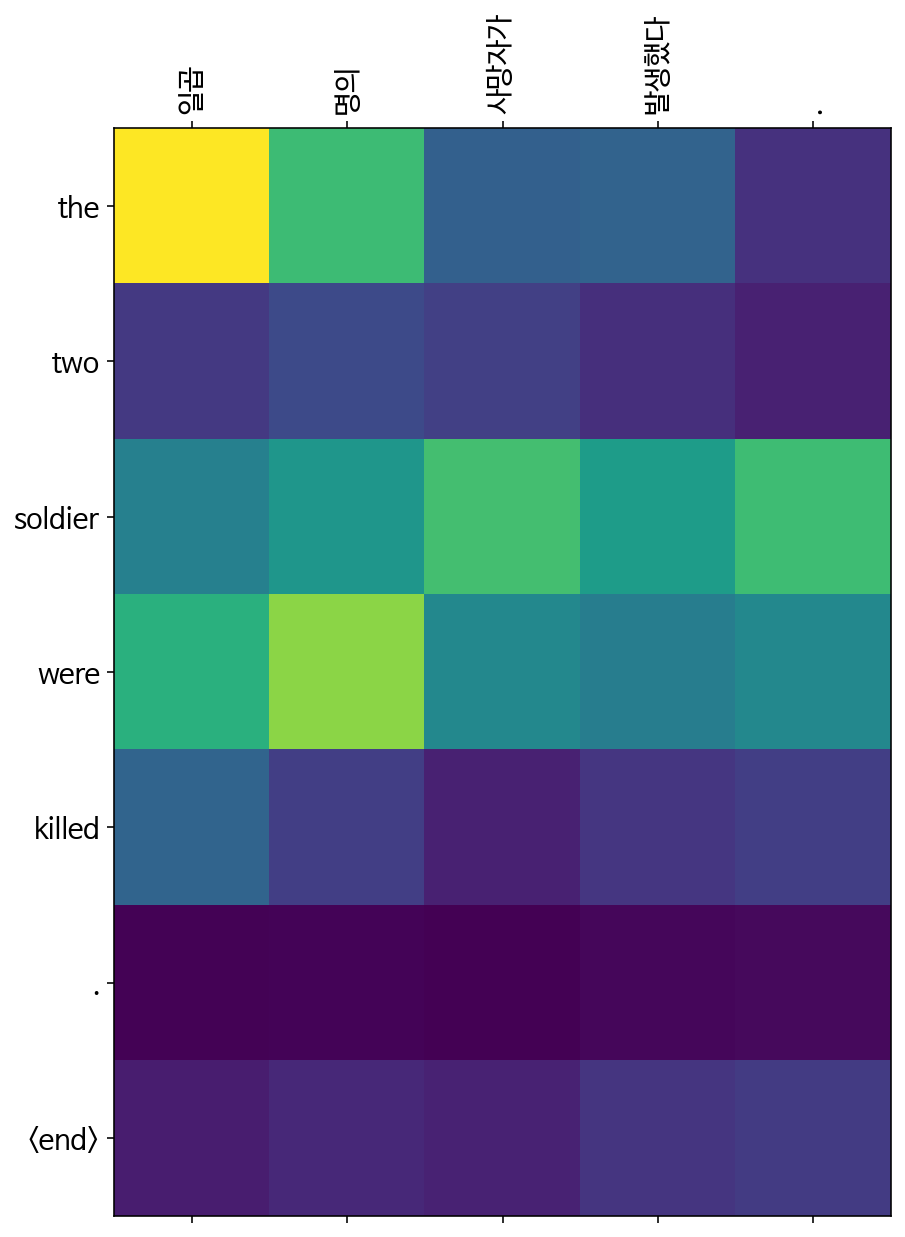

In [43]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = tokenizer.morphs(sentence)
    
    inputss = []
    for s in inputs:
        if s not in word_to_index:
                inputss.append(word_to_index['<UNK>'])
        else: inputss.append(word_to_index[s])
    inputs = [inputss]
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           value=word_to_index["<PAD>"],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''
    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']]*1, 0)

    
    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


str_t = "일곱 명의 사망자가 발생했다." 
translate(str_t, encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: it s a lot of your life . <end> 


/tmp/ipykernel_604/75899058.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_604/75899058.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


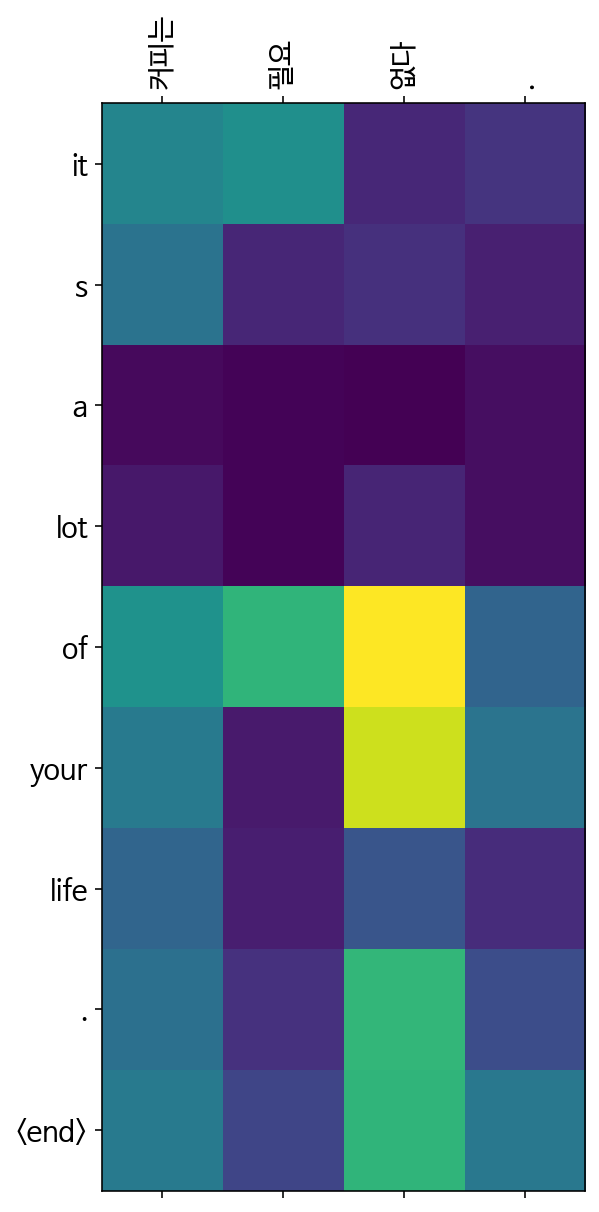

In [44]:
str_t = "커피는 필요 없다." 
translate(str_t, encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the dow is down . <end> 


/tmp/ipykernel_604/75899058.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_604/75899058.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


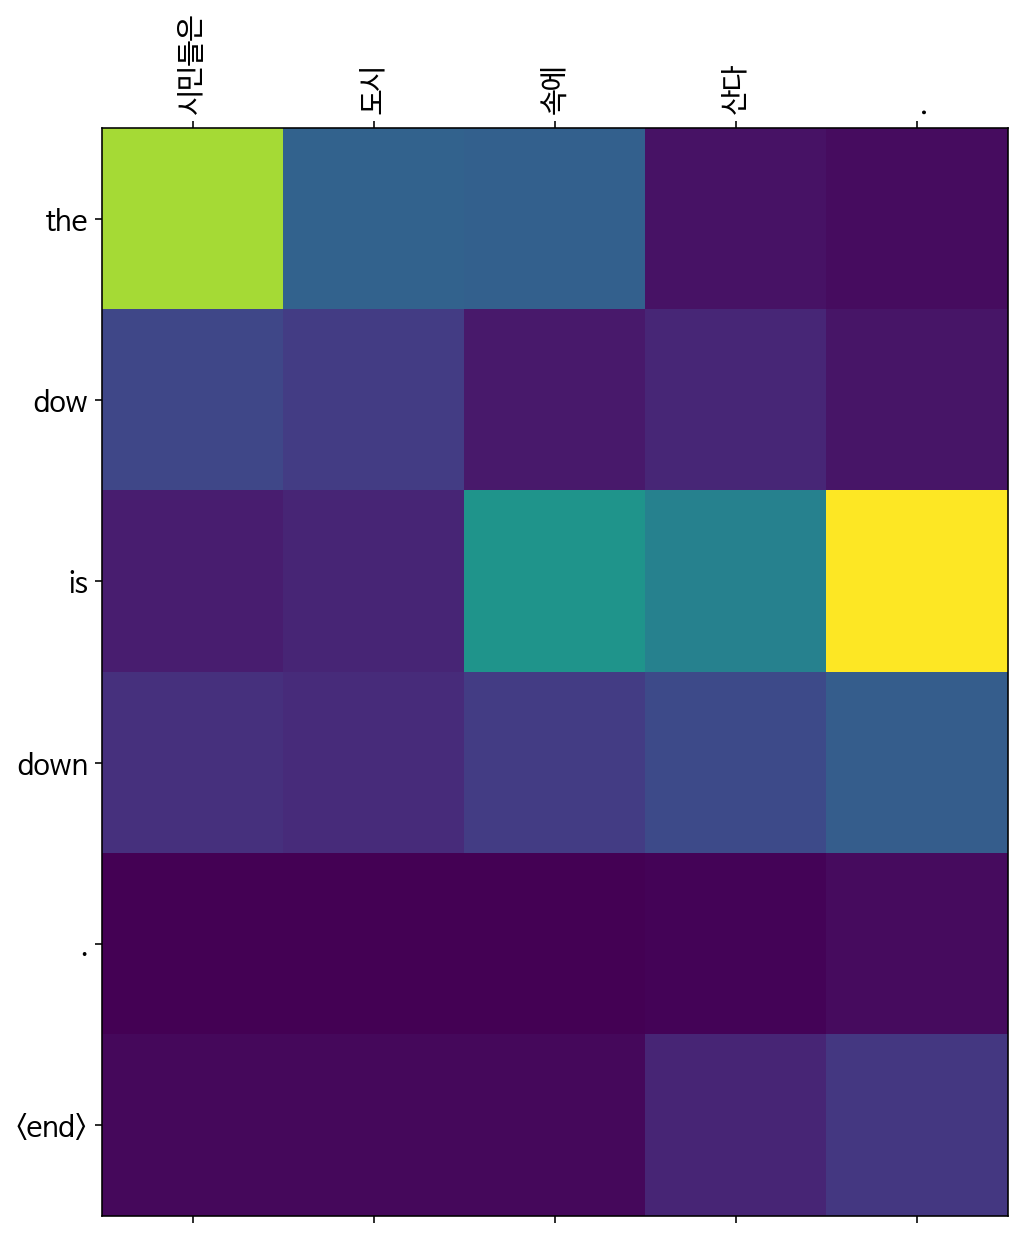

In [45]:
str_t = "시민들은 도시 속에 산다." 
translate(str_t, encoder, decoder)

Input: 오바마는 대통령이다 .
Predicted translation: obama s a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york is a new york 


/tmp/ipykernel_604/75899058.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_604/75899058.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


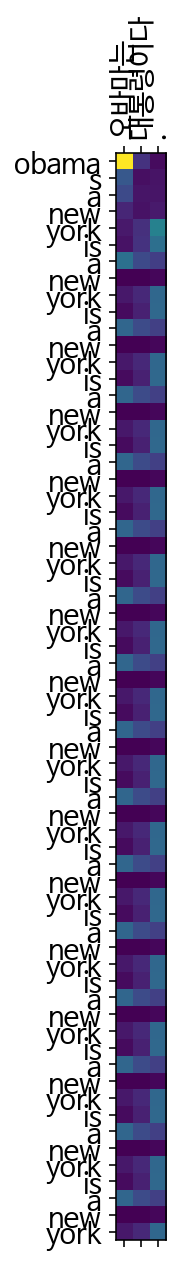

In [46]:
str_t = "오바마는 대통령이다." 
translate(str_t, encoder, decoder)

## 회고 
전처리는 정상적으로 된거 같은데 토큰화가 잘 되어있는건지 모르겠다. 
배웠던대로 한영 둘다 진행해보려했는데 모델평가시에 코드가 진행이 되지 않아 
한글은 아예 사전을 다시 만들어 진행하였다. 에러 내용은 디코더의 토큰이 없다고 말하는거 같은데 
분명 토큰을 추가 하였음에도 진행이 되지 않았다.. 간단한 번역기 만들기도 이렇게 어렵다니...
어떤 문제점에서 번역이 잘안되었는지 곰곰히 생각해보아야겠다. 그나마 일곱명의 사망자가 발생했다는 문장 번역이 
한글내용을 가지고 있던거 같다... 